In [1]:
# Load python packages
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.sparse as sparse
import statsmodels.api as sm

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
# Load R packages
library(edgeR)
library(DESeq2)
library(limma)
library(glmGamPoi)
library(glmmTMB)
library(nebula)
library(fixest)
library(MAST)
library(SingleCellExperiment)
library(scuttle)
library(lme4)

## Load data and save to AnnData

In [3]:
"""
%%time
# Load data and save to 
import gzip

genes = []
sps = []
with gzip.open('/scratch/hanbin973/GSE158769_exprs_raw.tsv.gz', 'rb') as f:
    line = f.readline()
    idx = 0
    while line:
        line = f.readline()
        str_split = line.decode('utf-8').split('\t')
        gene_name = str_split[0]
        counts = str_split[1:]
        
        # save gene name
        genes.append(gene_name)
        
        # convert to sparse
        n_sample = len(counts)
        sparse_line = sparse.csr_matrix(np.array(counts, dtype=np.float32), shape=(1,n_sample))
        sps.append(sparse_line)
        
        idx += 1
        if idx % 200 == 0:
            print(idx)
            
gene_counts = np.array([x.sum() for x in sps])
genes_nz = np.array(genes)[gene_counts > 0]
sps_nz = [x for x,y in zip(sps, gene_counts) if y]
sp_mat = sparse.vstack(sps_nz)
sp_mat_csr = sp_mat.T.tocsr()

cell_meta = pd.read_csv('data/Nathan/GSE158769_meta_data.txt.gz', sep='\t')
cell_meta

adata = sc.AnnData(sp_mat_csr, obs=cell_meta)
adata.var.index = genes_nz

adata.write('data/Nathan/nathan.h5ad')
"""

"\n%%time\n# Load data and save to \nimport gzip\n\ngenes = []\nsps = []\nwith gzip.open('/scratch/hanbin973/GSE158769_exprs_raw.tsv.gz', 'rb') as f:\n    line = f.readline()\n    idx = 0\n    while line:\n        line = f.readline()\n        str_split = line.decode('utf-8').split('\t')\n        gene_name = str_split[0]\n        counts = str_split[1:]\n        \n        # save gene name\n        genes.append(gene_name)\n        \n        # convert to sparse\n        n_sample = len(counts)\n        sparse_line = sparse.csr_matrix(np.array(counts, dtype=np.float32), shape=(1,n_sample))\n        sps.append(sparse_line)\n        \n        idx += 1\n        if idx % 200 == 0:\n            print(idx)\n            \ngene_counts = np.array([x.sum() for x in sps])\ngenes_nz = np.array(genes)[gene_counts > 0]\nsps_nz = [x for x,y in zip(sps, gene_counts) if y]\nsp_mat = sparse.vstack(sps_nz)\nsp_mat_csr = sp_mat.T.tocsr()\n\ncell_meta = pd.read_csv('data/Nathan/GSE158769_meta_data.txt.gz', sep='

## Load data

In [3]:
# Load data
adata = sc.read_h5ad('data/Nathan/nathan.h5ad')
adata.obs

,cell_id,nUMI,nGene,percent_mito,batch,TB_status,UMAP_1,UMAP_2,cluster_name,cluster_ids,donor,age,sex,season,prop_NAT
0,AAACCCAAGGCCTAAG-1,6108,1557,0.055828,1,CASE,-2.743703,1.617194,CD4+ CD27+,C-2,TB3419057,74,F,Summer,0.957475
1,AAACCCAAGGTTCTTG-1,7902,2149,0.083017,1,CASE,-4.237045,0.306832,CD4+ CCR4+ central,C-3,TB3419057,74,F,Summer,0.957475
2,AAACCCAAGTGCAGGT-1,5033,1788,0.129744,1,CASE,-1.136187,-4.012949,CD4+ Treg,C-9,TB3419057,74,F,Summer,0.957475
3,AAACCCACAAGAGTAT-1,6574,1747,0.066930,1,CASE,-1.015078,3.789505,CD4+ CD27+CD161+,C-4,TB3419057,74,F,Summer,0.957475
4,AAACCCACACACGGTC-1,6471,1872,0.047442,1,CASE,0.658381,2.427080,CD4+ Th17/1,C-13,TB0610655,41,M,Summer,0.975371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500084,TTTGTTGTCCGCCTAT-46,1945,833,0.183033,46,CASE,-2.568426,0.780417,CD4+ CD27+,C-2,TB9334348,28,M,Winter,0.596238
500085,TTTGTTGTCCTGGGTG-46,4534,1537,0.051610,46,CONTROL,1.017550,-0.594416,CD4+ Th1,C-17,TB2792656,9,F,Winter,0.599522
500086,TTTGTTGTCGATGGAG-46,3157,1013,0.081723,46,CASE,2.301589,0.623997,CD4+ Th17/1,C-16,TB7198118,59,F,Summer,0.943924
500087,TTTGTTGTCGTTTACT-46,3675,1202,0.089252,46,CASE,0.572390,-1.264730,CD4+ Th1,C-17,TB9334348,28,M,Winter,0.596238


In [4]:
adata.obs['cluster_name'].value_counts()

CD4+ CD27+CD161+           45519
CD4+ CD27+                 40431
CD4+ Th17/1                39205
CD4+ Th1                   37566
CD4+ CCR4+ central         28951
CD4+ CCR4+ICOS+ central    27770
CD4+ central               26701
CD4+ Treg                  25270
CD4+ cytotoxic             23213
CD4+ Th2                   20696
CD4+ lncRNA                19901
CD4+ CD161+ Th1            17731
CD4+ CCR4+                 17321
CD8+ GZMB+                 17085
CD4+ Th17                  16987
CD8+ GZMK+                 15225
CD4+ CD161+ Th2            13662
CD4+ CD161+ cytotoxic       9320
CD4/8+ PD-1+TIGIT+          8319
Vd2                         8144
CD4+ activated              8072
CD4+ HLA-DR+                6768
CD8+ central                6398
CD4+ CD38+ICOS+ central     4891
CD8+ CXCR3+                 4343
CD4+ CCR5+ cytotoxic        4241
CD4+ RORC+ Treg             3255
CD8+ activated              2508
Vd1                          336
Name: cluster_name, dtype: int64

In [5]:
adata.obs['donor'].unique().shape

(259,)

## Subsample to 5000 cells (randomly)

In [6]:
np.random.seed(0)
cell_idx_random = np.random.binomial(
    n=1,
    p=5000/adata.shape[0],
    size=adata.shape[0]
).astype(bool)
adata_sub = adata[cell_idx_random,:].copy()

## Benchmark preprocessing

1. Select cell-type.
2. Assign random treatment label.
3. Select transcripts with > 10 counts.
4. Output count matrix $\texttt{Y}$, design matrix $\texttt{X}$, size fator $\texttt{sf}$ and membership label.

In [7]:
# label definition: column name in adata.obs
var_celltype = 'cluster_name'
var_subject = 'donor'
var_treat_random = 'random_treat'

# assign random treatment label

adata_sub.obs.loc[:, var_treat_random] = np.random.binomial(
    n=1, 
    p=0.5, 
    size=adata_sub.shape[0]
)

# select transcripts with >10 counts
gene_idx_threshold = np.asarray(np.sum(adata_sub.X, axis=0) > 10).ravel()

# Produce Y, X, sf
matrix_count = adata_sub.X[:, gene_idx_threshold].tocsc()
matrix_design = sm.add_constant(
    pd.get_dummies(
        adata_sub.obs[var_treat_random], 
        drop_first=True
    )
).values
cell_sizefactor = np.asarray(np.sum(adata_sub.X, axis=1)).ravel()
cell_sizefactor = cell_sizefactor / cell_sizefactor.mean()
cell_subject = pd.factorize(adata_sub.obs[var_subject])[0]

## Pseudobulk generation

1. Aggregate(=sum) cell counts according to treatment & subject label

In [8]:
# convert psueobulk label to integer
cell_label_pseudobulk, subject_label = pd.factorize(
    adata_sub.obs[var_subject].astype(str) + 
    '_' + 
    adata_sub.obs[var_treat_random].astype(str)
)

# generate summation matrix
spmatrix_subject_sum = sparse.csc_matrix(
    (
        np.ones(adata_sub.shape[0]),
        cell_label_pseudobulk,
        np.arange(adata_sub.shape[0]+1)
    ),
    shape = (
        subject_label.shape[0], 
        adata_sub.shape[0]
    )
)

# generate pseudobulk count, design matrix
matrix_pb_count = spmatrix_subject_sum.dot(
    adata_sub.X
)[:, gene_idx_threshold].T
matrix_pb_design = sm.add_constant(
    pd.get_dummies(
        [x.split('_')[1] for x in subject_label], 
        drop_first=True
    )
).values


## Poisson regression (MLE)

In [ ]:
%%time
gene_beta_pr = np.zeros(matrix_count.shape[1])
gene_bse_pr = np.zeros(matrix_count.shape[1])
gene_p_pr = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_count[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_design, 
        family=sm.families.Poisson(), 
        offset=np.log(cell_sizefactor)
    )
    fit = mod.fit(tol=1e-10)
    gene_beta_pr[gene_idx_int] = fit.params[1]
    gene_bse_pr[gene_idx_int] = fit.bse[1]
    gene_p_pr[gene_idx_int] = fit.pvalues[1]

## Poisson regression (robust)

In [ ]:
%%time
gene_beta_rpr = np.zeros(matrix_count.shape[1])
gene_bse_rpr = np.zeros(matrix_count.shape[1])
gene_p_rpr = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_count[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_design, 
        family=sm.families.Poisson(), 
        offset=np.log(cell_sizefactor)
    )
    fit = mod.fit(cov_type='HC0', tol=1e-10)
    gene_beta_rpr[gene_idx_int] = fit.params[1]
    gene_bse_rpr[gene_idx_int] = fit.bse[1]
    gene_p_rpr[gene_idx_int] = fit.pvalues[1]

## Negative-binomial regression (statsmodels)

In [ ]:
%%time
gene_beta_nb = np.zeros(matrix_count.shape[1])
gene_bse_nb = np.zeros(matrix_count.shape[1])
gene_p_nb = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_count[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_design, 
        family=sm.families.NegativeBinomial(), 
        offset=np.log(cell_sizefactor)
    )
    fit = mod.fit(tol=1e-10)
    gene_beta_nb[gene_idx_int] = fit.params[1]
    gene_bse_nb[gene_idx_int] = fit.bse[1]
    gene_p_nb[gene_idx_int] = fit.pvalues[1]

## Negative-binomial regression (glmGamPoi, robust)

In [ ]:
gene_beta_ggp = np.zeros(matrix_count.shape[1])
gene_bse_ggp = np.zeros(matrix_count.shape[1])
gene_p_ggp = np.zeros(matrix_count.shape[1])
matrix_count_T = matrix_count.T.tocsc()

In [ ]:
%%time
%%R -i matrix_count_T -i matrix_design -i cell_sizefactor -o gene_beta_ggp -o gene_p_ggp

matrix_count_T <- as(matrix_count_T, "dgCMatrix")
fit <- glmGamPoi::glm_gp(
    matrix_count_T, 
    matrix_design, 
    on_disk=FALSE, 
    size_factors=as.numeric(cell_sizefactor)
    )
test <- glmGamPoi::test_de(fit, contrast=`Coef_2`)

gene_beta_ggp <- summary(fit)$Beta[,2]
gene_p_ggp <- test$pval

## Pseudobulk (edgeR)

In [ ]:
%%time
%%R -i matrix_pb_count -i matrix_pb_design -i subject_label -o gene_p_edger -o gene_beta_edger
y <- edgeR::DGEList(matrix_pb_count, group=subject_label)
y <- edgeR::calcNormFactors(y)
y <- edgeR::estimateDisp(y, matrix_pb_design)
fit <- edgeR::glmQLFit(y, matrix_pb_design)
qlf <- edgeR::glmQLFTest(fit, coef=2)

gene_p_edger <- qlf$table[,'PValue']
gene_beta_edger <- qlf$table[,'logFC']

## Pseudobulk (DESeq2)

In [ ]:
%%time
%%R -i matrix_pb_count -i matrix_pb_design -i subject_label -o gene_p_deseq2 -o gene_beta_deseq2
dds <- DESeq2::DESeqDataSetFromMatrix(
    matrix_pb_count,
    colData = matrix_pb_design,
    design = ~ 1+V2
)
dds <- DESeq2::estimateSizeFactors(dds)
dds <- DESeq2::estimateDispersions(dds, quiet = TRUE)
dds <- DESeq2::nbinomWaldTest(dds)
        
gene_beta_deseq2 <- results(dds)[,'log2FoldChange']
gene_p_deseq2 <- results(dds)[,'pvalue']

## Poisson mixed model (lme4)

In [ ]:
%%time
%%R -i matrix_count -i matrix_design -i cell_sizefactor -i cell_subject -o gene_beta_pmm -o gene_p_pmm

data <- matrix_count@x
row_indices <- matrix_count@i # i,p both 0-base like base R
indptr <- matrix_count@p

gene_beta_pmm <- rep(0, ncol(matrix_count))
gene_p_pmm <- rep(1, ncol(matrix_count))

for (gene_idx_int in 1:ncol(matrix_count)){
    # select gene from count matrix: manual indexing for speed
    y <- rep(0, nrow(matrix_count))
    y[row_indices[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]+1] <- data[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]
    
    # design matrix for fixest
    df_matrix_design <- as.data.frame(matrix_design)
    df <- cbind(y, cell_subject, df_matrix_design)
    
    # glmer fit
    fit <- glmmTMB::glmmTMB(y ~ V2 + (1|cell_subject), data=df, offset=log(cell_sizefactor), family=poisson)
    
    
    gene_beta_pmm[gene_idx_int] <- summary(fit)$coefficients$cond[2,1]
    gene_p_pmm[gene_idx_int] <- summary(fit)$coefficients$cond[2,4]   
}

## NB mixed model (glmmTMB)

In [ ]:
%%time
%%R -i matrix_count -i matrix_design -i cell_sizefactor -i cell_subject -o gene_beta_nbmm -o gene_p_nbmm

data <- matrix_count@x
row_indices <- matrix_count@i # i,p both 0-base like base R
indptr <- matrix_count@p

gene_beta_nbmm <- rep(0, ncol(matrix_count))
gene_p_nbmm <- rep(1, ncol(matrix_count))

for (gene_idx_int in 1:ncol(matrix_count)){
    # select gene from count matrix: manual indexing for speed
    y <- rep(0, nrow(matrix_count))
    y[row_indices[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]+1] <- data[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]
    
    # design matrix for fixest
    df_matrix_design <- as.data.frame(matrix_design)
    df <- cbind(y, cell_subject, df_matrix_design)
    
    # glmer fit
    fit <- glmmTMB::glmmTMB(y ~ V2 + (1|cell_subject), data=df, offset=log(cell_sizefactor), family=nbinom2)
    
    
    gene_beta_nbmm[gene_idx_int] <- summary(fit)$coefficients$cond[2,1]
    gene_p_nbmm[gene_idx_int] <- summary(fit)$coefficients$cond[2,4]   
}

## Result

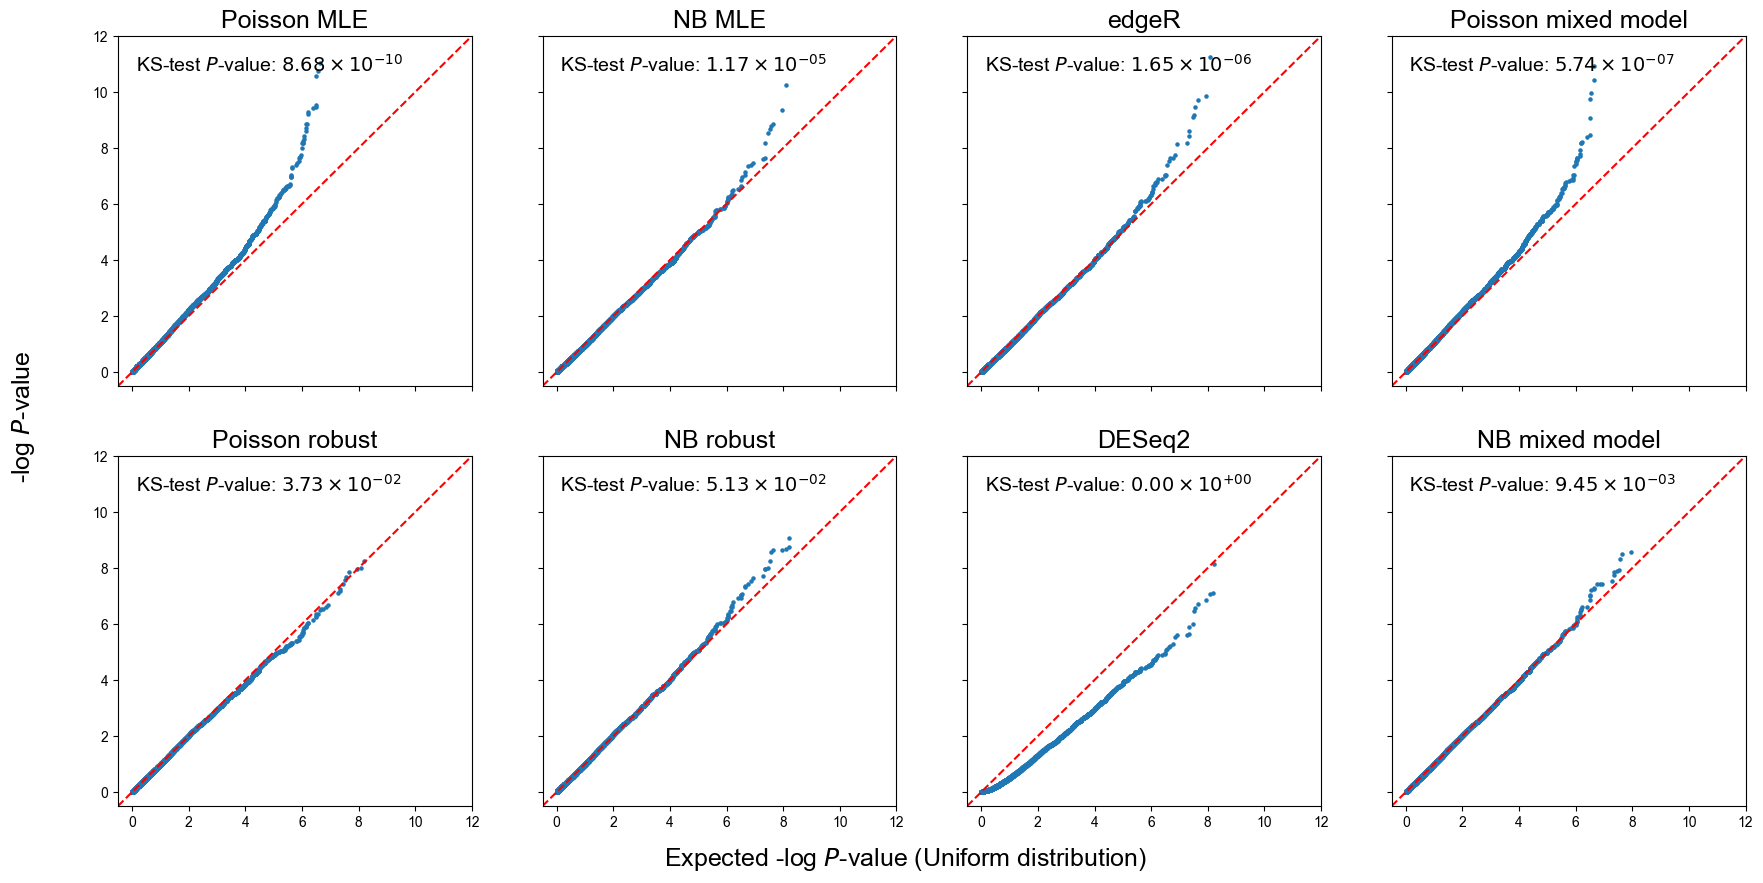

In [52]:
from decimal import Decimal
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(2, 4, figsize=(5*4+1,5*2), sharex=True, sharey=True)

p_unif = np.sort(-np.log(np.random.uniform(size=gene_p_pr.shape)))

# main scatters
#pvals = [gene_p_pr, gene_p_nb, gene_p_edger, gene_p_pmm, gene_p_rpr, gene_p_ggp, gene_p_deseq2, gene_p_nbmm]
labels= ['Poisson MLE', 'NB MLE', 'edgeR', 'Poisson mixed model', 'Poisson robust', 'NB robust', 'DESeq2', 'NB mixed model']
for i, pval, label in zip(range(8),pvals,labels):
    row, col = int(i/4), i%4

    ax[row, col].scatter(p_unif, np.sort(-np.log(pval)), s=5)
    ax[row, col].plot([-0.5, 15], [-0.5,15], ls='--', c='red')
    ax[row, col].set_title(label, fontsize=18)
    ks_pval = stats.kstest(np.sort(pval), stats.uniform.cdf)[1]
    
    if np.isnan(pval).sum():
        pval[np.isnan(pval)] = 1
        ks_pval = stats.kstest(np.sort(pval), stats.uniform.cdf)[1]
        base = ('%.2E' % Decimal(ks_pval)).split('E')[0]
        exp = ('%.2E' % Decimal(ks_pval)).split('E')[1]
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: $%s \times 10^{%s}$' % (base, exp),
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
    elif np.isnan(ks_pval):
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: <$2 \times 10^{-200}$',
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
    else:
        base = ('%.2E' % Decimal(ks_pval)).split('E')[0]
        exp = ('%.2E' % Decimal(ks_pval)).split('E')[1]
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: $%s \times 10^{%s}$' % (base, exp),
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
    
    

ax[0,0].set_xlim([-0.5, 12])
ax[0,0].set_ylim([-0.5, 12])    
fig.text(0.5, 0.05, r'Expected -log $P$-value (Uniform distribution)', fontsize=18, ha='center')
fig.text(0.08, 0.5, r'-log $P$-value', fontsize=18, rotation=90, ha='center', va='center')



plt.show()

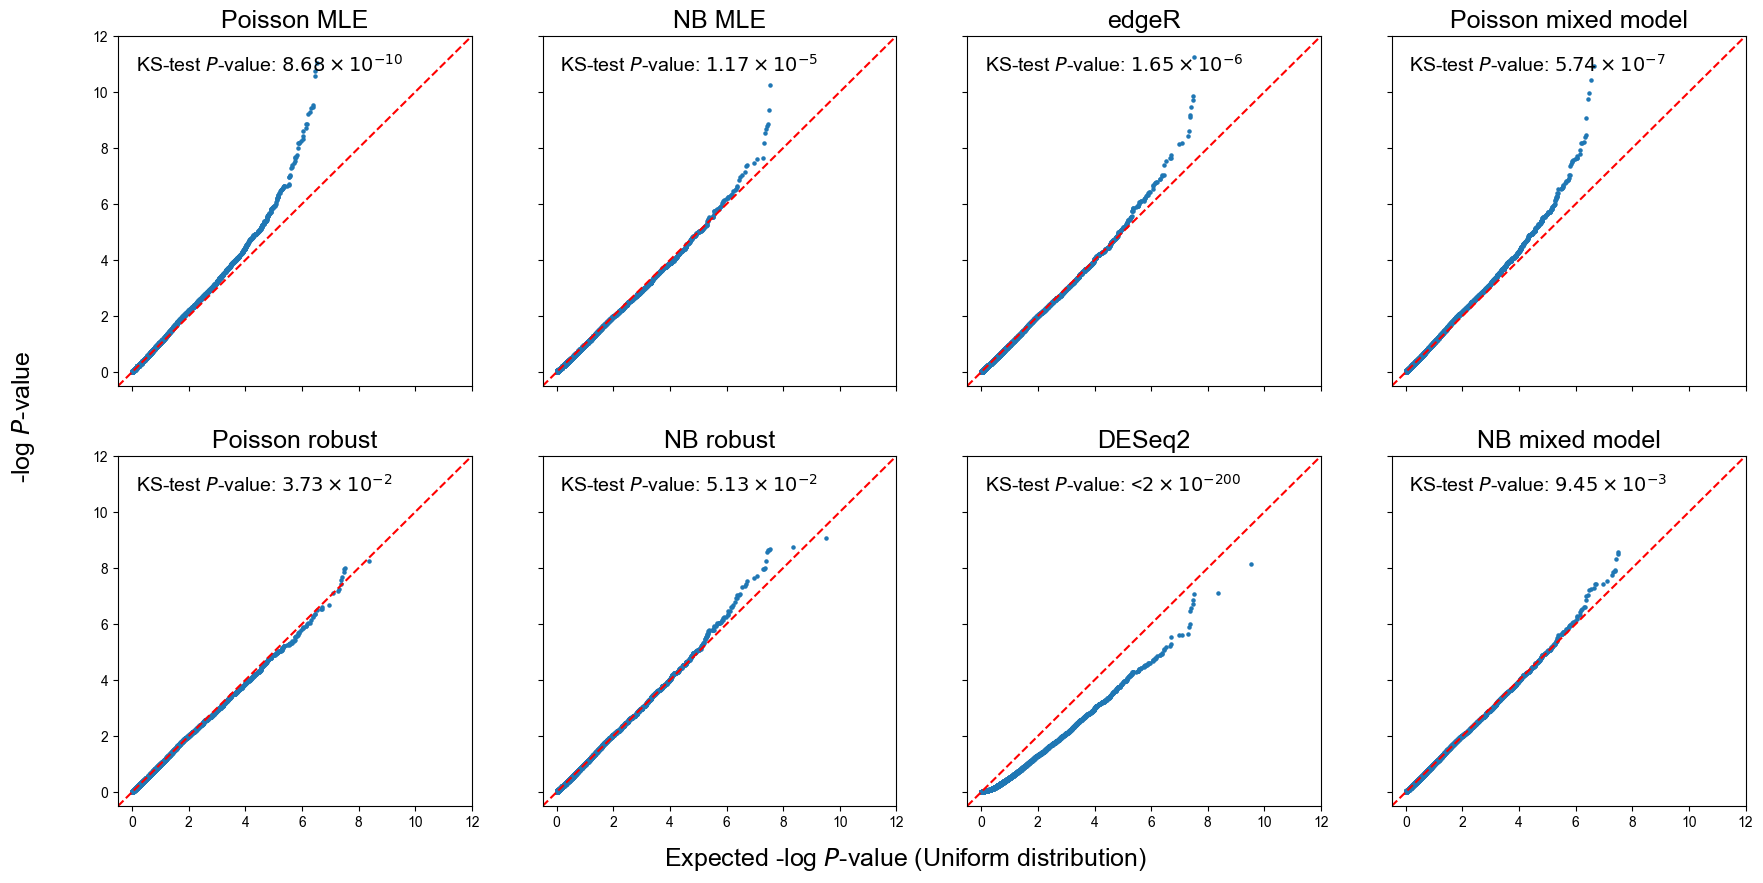

In [23]:
from decimal import Decimal
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(2, 4, figsize=(5*4+1,5*2), sharex=True, sharey=True)

p_unif = np.sort(-np.log(np.random.uniform(size=pvals[0].shape)))

# main scatters
#pvals = [gene_p_pr, gene_p_nb, gene_p_edger, gene_p_pmm, gene_p_rpr, gene_p_ggp, gene_p_deseq2, gene_p_nbmm]
labels= ['Poisson MLE', 'NB MLE', 'edgeR', 'Poisson mixed model', 'Poisson robust', 'NB robust', 'DESeq2', 'NB mixed model']
for i, pval, label in zip(range(8),pvals,labels):
    row, col = int(i/4), i%4

    ax[row, col].scatter(p_unif, np.sort(-np.log(pval)), s=5)
    ax[row, col].plot([-0.5, 15], [-0.5,15], ls='--', c='red')
    ax[row, col].set_title(label, fontsize=18)
    ks_pval = stats.kstest(np.sort(pval), stats.uniform.cdf)[1]
    
    if np.isnan(pval).sum():
        pval[np.isnan(pval)] = 1
        ks_pval = stats.kstest(np.sort(pval), stats.uniform.cdf)[1]
        base = ('%.2E' % Decimal(ks_pval)).split('E')[0]
        exp = ('%.2E' % Decimal(ks_pval)).split('E')[1]
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: $%s \times 10^{%s}$' % (base, exp),
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
    elif np.isnan(ks_pval) or (ks_pval<2e-100):
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: <$2 \times 10^{-200}$',
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
    else:
        base = ('%.2E' % Decimal(ks_pval)).split('E')[0]
        exp = ('%.2E' % Decimal(ks_pval)).split('E')[1]
        if exp[1] == '0':
            exp = exp[0]+exp[2] 
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: $%s \times 10^{%s}$' % (base, exp),
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
    
    

ax[0,0].set_xlim([-0.5, 12])
ax[0,0].set_ylim([-0.5, 12])    
fig.text(0.5, 0.05, r'Expected -log $P$-value (Uniform distribution)', fontsize=18, ha='center')
fig.text(0.08, 0.5, r'-log $P$-value', fontsize=18, rotation=90, ha='center', va='center')



plt.show()

In [21]:
import pickle
 
## Save pickle
with open("pvals_nathan_5000.pickle","wb") as fw:
    pickle.dump(pvals, fw)


In [4]:
import pickle

## Load pickle
with open("pvals_nathan_5000.pickle","rb") as fr:
    pvals = pickle.load(fr)

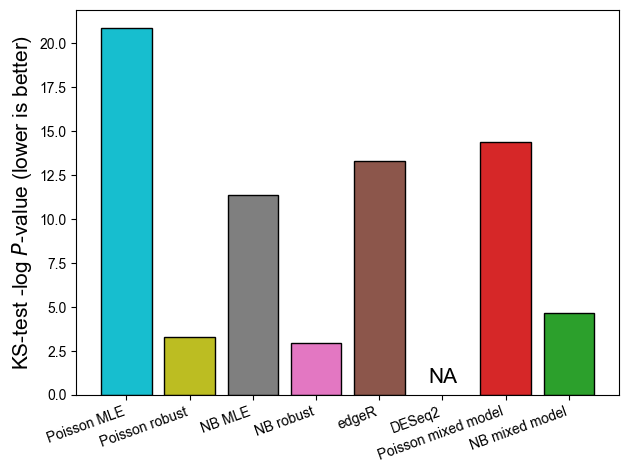

In [64]:
import matplotlib

cmap = matplotlib.cm.get_cmap('tab10_r')


fig, ax = plt.subplots(figsize=(7,5))

#labels= ['Poisson MLE', 'NB MLE', 'edgeR', 'Poisson mixed model', 'Poisson robust', 'NB robust', 'DESeq2', 'NB mixed model']
labels = ['Poisson MLE', 'Poisson robust', 'NB MLE', 'NB robust', 'edgeR', 'DESeq2', 'Poisson mixed model', 'NB mixed model']
pvalss = [pvals[i] for i in [0,4,1,5,2,6,3,7]]
ks_pvals = []
for i, pval in enumerate(pvalss):
    ks_pval = stats.kstest(pval, stats.uniform.cdf)[1]
    ks_pvals.append(ks_pval)

ax.bar(
    labels, 
    -np.log(ks_pvals),
    color=cmap((range(len(pvals)))),
    edgecolor='black')

# axis legend
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')
ax.set_ylabel('KS-test -log $\it{P}$-value (lower is better)', fontsize=15)

# DEseq2 legend
ax.text(5, 1, 'NA', ha='center', va='center', fontsize=15)


plt.show()

## Supplementary

In [88]:
%%time
%%R -i matrix_pb_count -i matrix_pb_design -i subject_label -o gene_p_pb_ggp -o gene_beta_pb_ggp -o size_factor_pb

fit <- glmGamPoi::glm_gp(
    as.matrix(matrix_pb_count),
    matrix_pb_design,
    on_disk=FALSE
)
test <- glmGamPoi::test_de(fit, contrast=`Coef_2`)

gene_beta_pb_ggp <- summary(fit)$Beta[,2]
gene_p_pb_ggp <- test$pval
size_factor_pb <- fit$size_factors

CPU times: user 6min 52s, sys: 16.2 s, total: 7min 8s
Wall time: 45.8 s


In [ ]:
%%time
gene_beta_pb_pr = np.zeros(matrix_count.shape[1])
gene_bse_pb_pr = np.zeros(matrix_count.shape[1])
gene_p_pb_pr = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_pb_count.T[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_pb_design, 
        family=sm.families.Poisson(), 
        offset=np.log(size_factor_pb)
    )
    fit = mod.fit(tol=1e-10)
    gene_beta_pb_pr[gene_idx_int] = fit.params[1]
    gene_bse_pb_pr[gene_idx_int] = fit.bse[1]
    gene_p_pb_pr[gene_idx_int] = fit.pvalues[1]

In [ ]:
%%time
gene_beta_pb_nb = np.zeros(matrix_count.shape[1])
gene_bse_pb_nb = np.zeros(matrix_count.shape[1])
gene_p_pb_nb = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_pb_count.T[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_pb_design, 
        family=sm.families.NegativeBinomial(), 
        offset=np.log(size_factor_pb)
    )
    fit = mod.fit(tol=1e-10)
    gene_beta_pb_nb[gene_idx_int] = fit.params[1]
    gene_bse_pb_nb[gene_idx_int] = fit.bse[1]
    gene_p_pb_nb[gene_idx_int] = fit.pvalues[1]

In [ ]:
%%time
gene_beta_pb_rpr = np.zeros(matrix_count.shape[1])
gene_bse_pb_rpr = np.zeros(matrix_count.shape[1])
gene_p_pb_rpr = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_pb_count.T[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_pb_design, 
        family=sm.families.Poisson(), 
        offset=np.log(size_factor_pb) 
    )
    fit = mod.fit(cov_type='HC0', tol=1e-10)
    gene_beta_pb_rpr[gene_idx_int] = fit.params[1]
    gene_bse_pb_rpr[gene_idx_int] = fit.bse[1]
    gene_p_pb_rpr[gene_idx_int] = fit.pvalues[1]

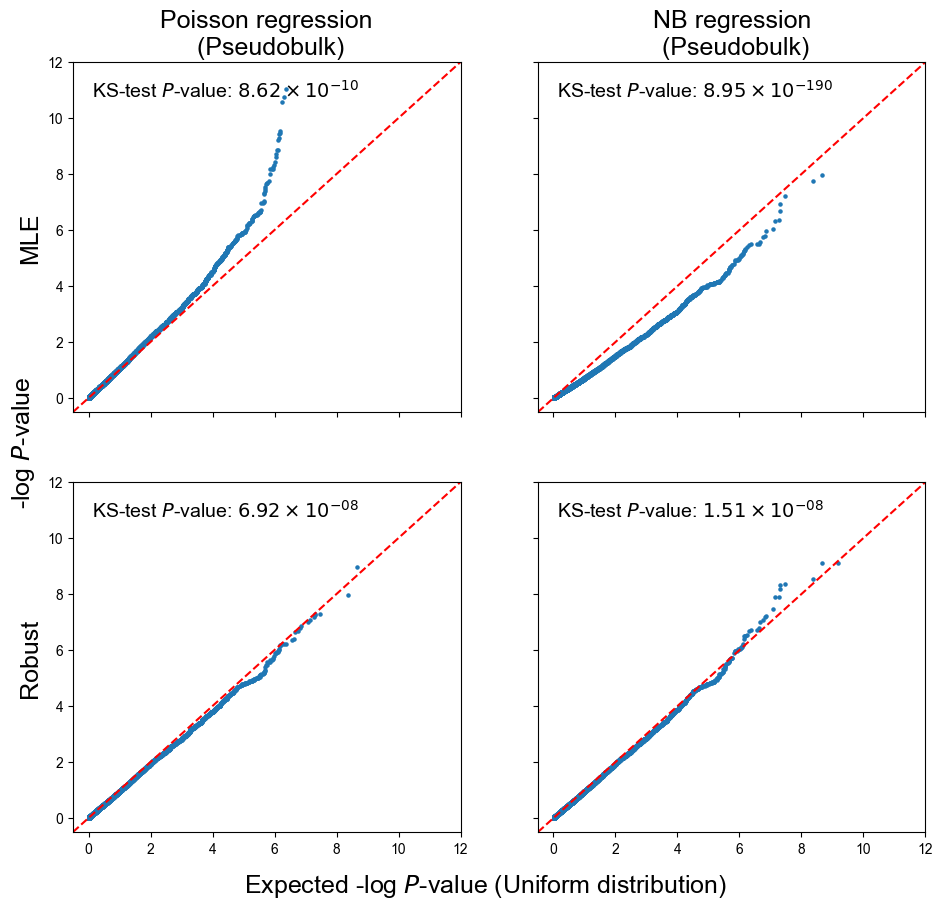

In [89]:
from decimal import Decimal
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(2, 2, figsize=(5*2+1,5*2), sharex=True, sharey=True)

p_unif = np.sort(-np.log(np.random.uniform(size=gene_p_pr.shape)))

# main scatters
pvals = [gene_p_pb_pr, gene_p_pb_nb, gene_p_pb_rpr, gene_p_pb_ggp]
labels= ['Poisson regression\n (Pseudobulk)', 'NB regression\n (Pseudobulk)', '', '']
for i, pval, label in zip(range(4),pvals,labels):
    row, col = int(i/2), i%2

    ax[row, col].scatter(p_unif, np.sort(-np.log(pval)), s=5)
    ax[row, col].plot([-0.5, 15], [-0.5,15], ls='--', c='red')
    ax[row, col].set_title(label, fontsize=18)
    ks_pval = stats.kstest(np.sort(pval), stats.uniform.cdf)[1]
    
    if np.isnan(pval).sum():
        pval[np.isnan(pval)] = 1
        ks_pval = stats.kstest(np.sort(pval), stats.uniform.cdf)[1]
        base = ('%.2E' % Decimal(ks_pval)).split('E')[0]
        exp = ('%.2E' % Decimal(ks_pval)).split('E')[1]
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: $%s \times 10^{%s}$' % (base, exp),
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
    elif np.isnan(ks_pval):
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: <$2 \times 10^{-200}$',
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
    else:
        base = ('%.2E' % Decimal(ks_pval)).split('E')[0]
        exp = ('%.2E' % Decimal(ks_pval)).split('E')[1]
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: $%s \times 10^{%s}$' % (base, exp),
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
        
    if col == 0:
        if row == 0:
            ax[row,col].set_ylabel('MLE', fontsize=18)
        else:
            ax[row,col].set_ylabel('Robust', fontsize=18)
    

ax[0,0].set_xlim([-0.5, 12])
ax[0,0].set_ylim([-0.5, 12])    
fig.text(0.5, 0.05, r'Expected -log $P$-value (Uniform distribution)', fontsize=18, ha='center')
fig.text(0.08, 0.5, r'-log $P$-value', fontsize=18, rotation=90, ha='center', va='center')



plt.show()

## Supp 2

In [59]:
%%time
gene_beta_pb_cpr = np.zeros(matrix_count.shape[1])
gene_bse_pb_cpr = np.zeros(matrix_count.shape[1])
gene_p_pb_cpr = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_count[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_design, 
        family=sm.families.Poisson(), 
        offset=np.log(cell_sizefactor)
    )
    fit = mod.fit(cov_type='cluster', tol=1e-10, cov_kwds={'groups':cell_subject})
    gene_beta_pb_cpr[gene_idx_int] = fit.params[1]
    gene_bse_pb_cpr[gene_idx_int] = fit.bse[1]
    gene_p_pb_cpr[gene_idx_int] = fit.pvalues[1]

CPU times: user 1h 34min 7s, sys: 3h 40min 21s, total: 5h 14min 28s
Wall time: 12min 29s


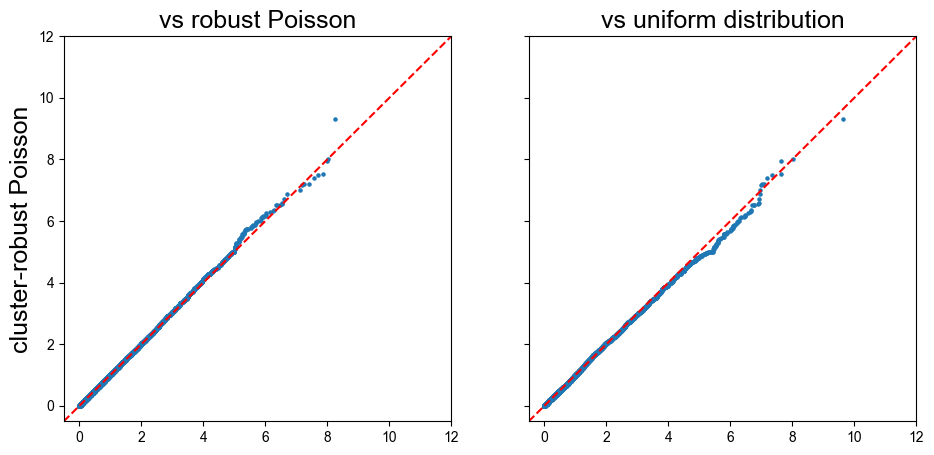

In [83]:
from decimal import Decimal
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(1, 2, figsize=(5*2+1,5*1), sharex=True, sharey=True)

p_unif = np.random.uniform(size=gene_p_pr.shape)

# main scatters
pvals = [gene_p_rpr, p_unif]
labels= ['vs robust Poisson', 'vs uniform distribution']
for i, pval, label in zip(range(4),pvals,labels):
    row, col = int(i/2), i%2

    ax[col].scatter(np.sort(-np.log(pval)), np.sort(-np.log(gene_p_pb_cpr)), s=5)
    ax[col].plot([-0.5, 15], [-0.5,15], ls='--', c='red')
    ax[col].set_title(label, fontsize=18) 

    if col == 0:
        if row == 0:
            ax[col].set_ylabel('cluster-robust Poisson', fontsize=18)
    

ax[0].set_xlim([-0.5, 12])
ax[0].set_ylim([-0.5, 12])    

plt.show()